In [30]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.models import load_model

In [31]:
IMAGE_SIZE = (160, 160)  # Match FaceNet size
REFERENCE_DIR = "/content/drive/MyDrive/TASK_B/Reference"
DISTORTED_DIR = "/content/drive/MyDrive/TASK_B/Distorted"

def load_and_preprocess_image(path):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Image not found: {path}")

    img = cv2.resize(img, IMAGE_SIZE)

    # Filtering
    img = cv2.medianBlur(img, 3)                      # Salt-and-pepper denoising
    img = cv2.GaussianBlur(img, (3, 3), 0)            # Light smoothing

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)       # Grayscale conversion
    # Removed: Histogram equalization (contrast boost)

    img = img.astype("float32") / 255.0               # Normalize to [0, 1]

    return np.expand_dims(img, axis=-1)               # Add channel dimension


In [32]:
def get_identity_name(filename):
    parts = filename.split("_")  # Fixed: Use "_" as delimiter
    if len(parts) >= 2:
        return f"{parts[0]}_{parts[1]}"
    return os.path.splitext(filename)[0]

def generate_pairs():
    X1, X2, y = [], [], []
    identity_to_ref = {}

    # Load reference images
    for fname in os.listdir(REFERENCE_DIR):
        identity = os.path.splitext(fname)[0].lower()
        ref_path = os.path.join(REFERENCE_DIR, fname)
        identity_to_ref[identity] = load_and_preprocess_image(ref_path)

    # Loop over distorted images
    for dname in tqdm(os.listdir(DISTORTED_DIR)):
        if not dname.lower().endswith((".jpg", ".png")):
            continue

        distorted_path = os.path.join(DISTORTED_DIR, dname)
        distorted_identity = get_identity_name(dname).lower()

        if distorted_identity not in identity_to_ref:
            continue

        distorted_img = load_and_preprocess_image(distorted_path)

        # Positive pair
        X1.append(identity_to_ref[distorted_identity])
        X2.append(distorted_img)
        y.append(1)

        # Negative pairs (2 random others)
        negative_ids = [k for k in identity_to_ref if k != distorted_identity]
        for neg_id in random.sample(negative_ids, min(2, len(negative_ids))):
            X1.append(identity_to_ref[neg_id])
            X2.append(distorted_img)
            y.append(0)

    # Print statistics
    y_arr = np.array(y)
    num_total = len(y_arr)
    num_pos = np.sum(y_arr == 1)
    num_neg = np.sum(y_arr == 0)

    print(f"\n Total Pairs: {num_total}")
    print(f" Positive Pairs: {num_pos}")
    print(f" Negative Pairs: {num_neg}")

    return np.array(X1), np.array(X2), y_arr

# Call to generate data
X1, X2, y = generate_pairs()


100%|██████████| 250/250 [00:06<00:00, 35.76it/s] 


 Total Pairs: 750
 Positive Pairs: 250
 Negative Pairs: 500


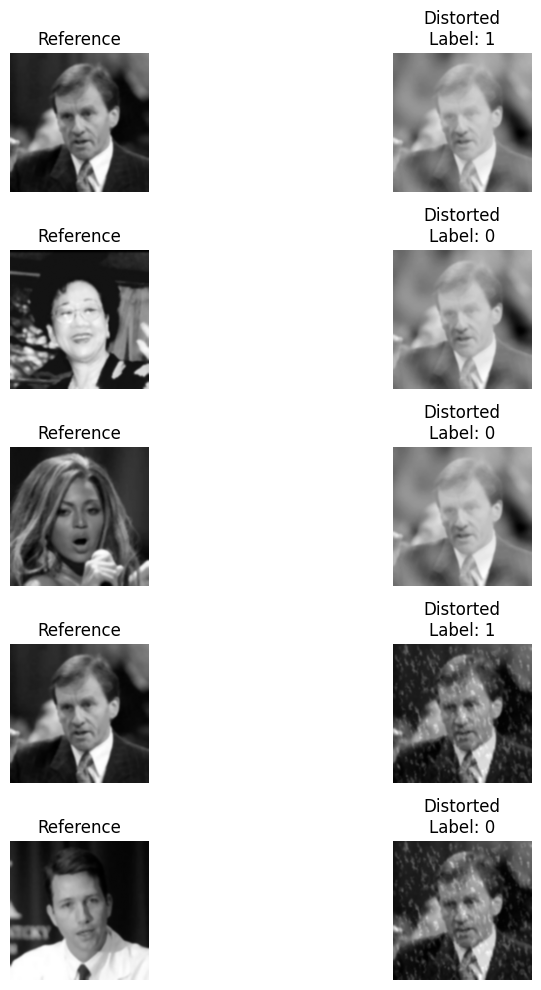

In [33]:
import matplotlib.pyplot as plt

def show_sample_pairs(X1, X2, y, n=5):
    plt.figure(figsize=(10, 2 * n))
    for i in range(n):
        ax1 = plt.subplot(n, 2, 2 * i + 1)
        ax2 = plt.subplot(n, 2, 2 * i + 2)

        ax1.imshow(X1[i].squeeze(), cmap='gray')
        ax1.set_title("Reference")
        ax1.axis('off')

        ax2.imshow(X2[i].squeeze(), cmap='gray')
        ax2.set_title(f"Distorted\nLabel: {y[i]}")
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
show_sample_pairs(X1, X2, y)


In [34]:
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

In [37]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

def build_embedding_model(input_shape):
    def simple_cnn(x):
        x = layers.Conv2D(64, (10, 10), activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(128, (7, 7), activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(128, (4, 4), activation='relu')(x)
        x = layers.Flatten()(x)
        return x

    input_img = Input(shape=input_shape)

    # Stream 1: CNN
    cnn_out = simple_cnn(input_img)

    # Stream 2: ResNet50 (convert grayscale to 3-channel)
    preeti = layers.Concatenate()([input_img] * 3)  # renamed from x3 to preeti
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(160, 160, 3), pooling='avg')
    resnet.trainable = False
    resnet_out = resnet(preeti)

    # Stream 3: FaceNet-like mock (shallow)
    face_out = layers.Conv2D(32, (3, 3), activation='relu')(input_img)
    face_out = layers.GlobalAveragePooling2D()(face_out)
    face_out = layers.Dense(128, activation='relu')(face_out)

    # Combine all embeddings
    combined = layers.Concatenate()([cnn_out, resnet_out, face_out])
    output = layers.Dense(256, activation='relu')(combined)

    return Model(input_img, output, name="EnsembleEmbedding")

def build_siamese_network(input_shape=(160, 160, 1)):
    embedding_net = build_embedding_model(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    emb_a = embedding_net(input_a)
    emb_b = embedding_net(input_b)

    # L1 distance
    diff = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([emb_a, emb_b])
    out = layers.Dense(1, activation='sigmoid')(diff)

    return Model(inputs=[input_a, input_b], outputs=out, name="SiameseEnsemble")


In [38]:
model = build_siamese_network()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit([X1_train, X2_train], y_train,
validation_data=([X1_val, X2_val], y_val),
batch_size=16, epochs=20)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 670ms/step - accuracy: 0.6869 - loss: 0.4872 - val_accuracy: 0.8333 - val_loss: 0.3682
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.8387 - loss: 0.3605 - val_accuracy: 0.8200 - val_loss: 0.2985
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.8904 - loss: 0.2963 - val_accuracy: 0.8667 - val_loss: 0.3013
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9131 - loss: 0.2650 - val_accuracy: 0.8267 - val_loss: 0.3880
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.8942 - loss: 0.3021 - val_accuracy: 0.8600 - val_loss: 0.2739
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.9300 - loss: 0.3009 - val_accuracy: 0.8667 - val_loss: 0.3875
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9236 - loss: 0.2383 - val_accuracy: 0.9000 - val_loss: 0.2751
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.9551 - loss: 0.2188 - val_accur

In [42]:
y_pred_prob = model.predict([X1_val, X2_val])
y_pred = (y_pred_prob > 0.5).astype("int32")

acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_prob)

print(f" Accuracy: {acc:.4f}, \n Precision: {prec:.4f}, \nRecall: {rec:.4f}, \nF1: {f1:.4f}, \nAUC: {auc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
 Accuracy: 0.9133, 
 Precision: 0.7857,
Recall: 0.9778, 
F1: 0.8713, 
AUC: 0.9329


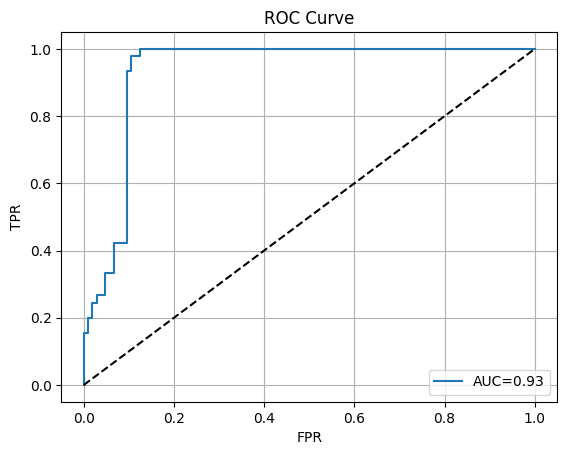

In [43]:
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--'); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curve"); plt.legend(); plt.grid(); plt.show()

In [44]:
print("\n Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("\n Classification Report:\n", classification_report(y_val, y_pred))


 Confusion Matrix:
 [[93 12]
 [ 1 44]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.93       105
           1       0.79      0.98      0.87        45

    accuracy                           0.91       150
   macro avg       0.89      0.93      0.90       150
weighted avg       0.93      0.91      0.92       150



In [13]:
# Evaluate Top-1 Accuracy and Macro F1 by matching distorted images to reference identities using cosine similarity

from sklearn.metrics import f1_score, accuracy_score
from collections import defaultdict

def evaluate_top1_and_macro_f1(model, reference_dir=REFERENCE_DIR, distorted_dir=DISTORTED_DIR, threshold=0.5):
    # Load reference embeddings
    identity_to_embedding = {}
    identity_to_name = {}

    for fname in os.listdir(reference_dir):
        if not fname.lower().endswith((".jpg", ".png")):
            continue
        identity = os.path.splitext(fname)[0].lower()
        path = os.path.join(reference_dir, fname)
        img = load_and_preprocess_image(path)
        emb = model.get_layer("EnsembleEmbedding")(np.expand_dims(img, axis=0)).numpy()
        identity_to_embedding[identity] = emb
        identity_to_name[identity] = fname

    y_true, y_pred = [], []

    # Predict on distorted images
    for dname in tqdm(os.listdir(distorted_dir)):
        if not dname.lower().endswith((".jpg", ".png")):
            continue

        distorted_identity = get_identity_name(dname).lower()
        if distorted_identity not in identity_to_embedding:
            continue  # Skip unknown identities

        distorted_path = os.path.join(distorted_dir, dname)
        distorted_img = load_and_preprocess_image(distorted_path)
        distorted_emb = model.get_layer("EnsembleEmbedding")(np.expand_dims(distorted_img, axis=0)).numpy()

        best_score = -1
        best_match = None

        for ref_id, ref_emb in identity_to_embedding.items():
            score = tf.keras.backend.eval(tf.keras.losses.cosine_similarity(ref_emb, distorted_emb))[0]
            score = 1 - score  # Convert cosine distance to similarity

            if score > best_score:
                best_score = score
                best_match = ref_id

        y_true.append(distorted_identity)
        y_pred.append(best_match)

    # Evaluation metrics
    top1_acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    print(f"\n Top-1 Accuracy: {top1_acc:.4f}")
    print(f" Macro-averaged F1 Score: {macro_f1:.4f}")

    return top1_acc, macro_f1


In [14]:
evaluate_top1_and_macro_f1(model)


100%|██████████| 250/250 [01:35<00:00,  2.62it/s]


 Top-1 Accuracy: 0.8520
 Macro-averaged F1 Score: 0.8633


(0.852, 0.8633391608391606)

Testing from Training Dataset


 Enter path to distorted test image: /content/drive/MyDrive/TASK_B/Distorted/P_10_blurred.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/s

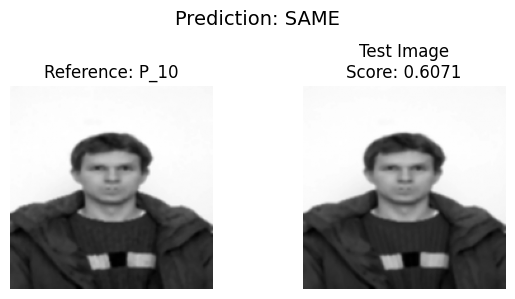

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

def predict_identity_from_input(model, reference_dir=REFERENCE_DIR, threshold=0.5):
    # Ask for test image path
    test_img_path = input(" Enter path to distorted test image: ").strip()

    if not os.path.exists(test_img_path):
        print(" File not found.")
        return

    #  Preprocess distorted image
    test_img = load_and_preprocess_image(test_img_path)
    test_input = np.expand_dims(test_img, axis=0)

    best_match = None
    best_score = 0.0
    best_ref_img = None

    # Loop over reference images
    for ref_name in os.listdir(reference_dir):
        if not ref_name.lower().endswith((".jpg", ".png")):
            continue

        ref_path = os.path.join(reference_dir, ref_name)
        ref_img = load_and_preprocess_image(ref_path)
        ref_input = np.expand_dims(ref_img, axis=0)

        # Predict similarity
        score = model.predict([ref_input, test_input])[0][0]

        if score > best_score:
            best_score = score
            best_match = os.path.splitext(ref_name)[0]
            best_ref_img = ref_img

    # Final decision
    print("\n Prediction Result:")
    print(f" Best Match: {best_match if best_score >= threshold else 'None'}")
    print(f" Confidence Score: {best_score:.4f}")
    print(" SAME person" if best_score >= threshold else "DIFFERENT person")

    # Show both images
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(best_ref_img.squeeze(), cmap='gray')
    plt.title(f"Reference: {best_match}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(test_img.squeeze(), cmap='gray')
    plt.title(f"Test Image\nScore: {best_score:.4f}")
    plt.axis('off')

    plt.suptitle("Prediction: " + ("SAME" if best_score >= threshold else "DIFFERENT"), fontsize=14)
    plt.tight_layout()
    plt.show()
# After training your Siamese model
predict_identity_from_input(model)


 Enter path to distorted test image: /content/drive/MyDrive/TASK_B/Distorted/P_12_noisy.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/s

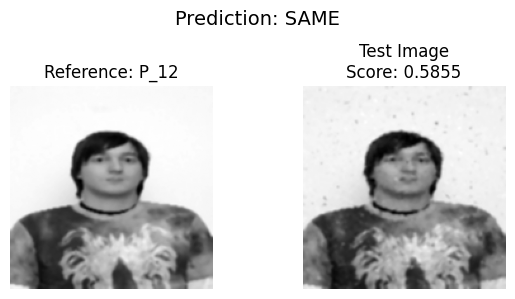

In [16]:
# After training your Siamese model
predict_identity_from_input(model)

 Enter path to distorted test image: /content/drive/MyDrive/TASK_B/Distorted/P_13_resized.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms

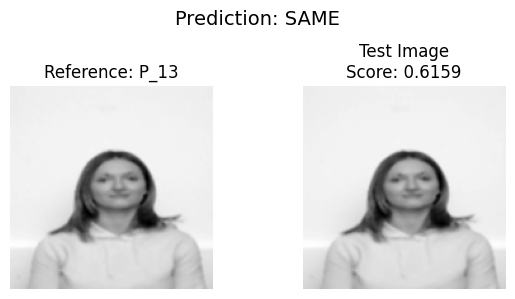

In [17]:
# After training your Siamese model
predict_identity_from_input(model)

 Enter path to distorted test image: /content/drive/MyDrive/TASK_B/Distorted/P_14_rainy.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/

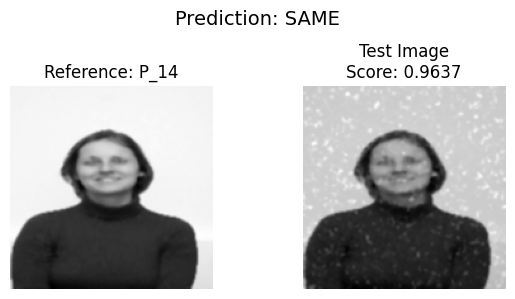

In [18]:
# After training your Siamese model
predict_identity_from_input(model)

📁 Enter path to distorted test image: /content/drive/MyDrive/TASK_B/Distorted/P_25_blurred.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56m

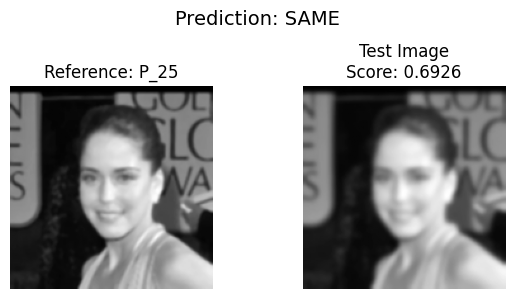

In [ ]:
# After training your Siamese model
predict_identity_from_input(model)

📁 Enter path to distorted test image: /content/drive/MyDrive/TASK_B/Distorted/P_40_foggy.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/

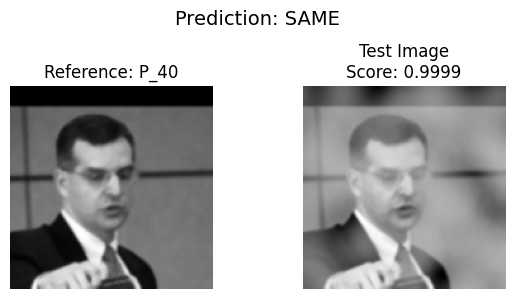

In [ ]:
# After training your Siamese model
predict_identity_from_input(model)

In [21]:
from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f" Optimal Threshold: {optimal_threshold:.4f}")


 Optimal Threshold: 0.0684


In [23]:
def verify_pair(img1_path, img2_path, model, threshold=0.5):
    img1 = load_and_preprocess_image(img1_path)
    img2 = load_and_preprocess_image(img2_path)
    img1 = np.expand_dims(img1, axis=0)
    img2 = np.expand_dims(img2, axis=0)

    score = model.predict([img1, img2])[0][0]
    print(f"\n Confidence Score: {score:.4f}")
    print(" SAME person" if score > threshold else " DIFFERENT persons")

    # Show side-by-side
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img1.squeeze(), cmap='gray')
    plt.title("Image 1")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2.squeeze(), cmap='gray')
    plt.title("Image 2")
    plt.axis('off')

    plt.suptitle(f"{'SAME' if score >= threshold else 'DIFFERENT'} ({score:.2f})", fontsize=14)
    plt.tight_layout()
    plt.show()



Enter Reference Image Path: /content/drive/MyDrive/Large_task_B/train/Aaron_Pena/Aaron_Pena_0001.jpg
Enter Distorted Image Path: /content/drive/MyDrive/Large_task_B/train/Aaron_Pena/distortion/Aaron_Pena_0001_noisy.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

 Confidence Score: 0.6501
 SAME person


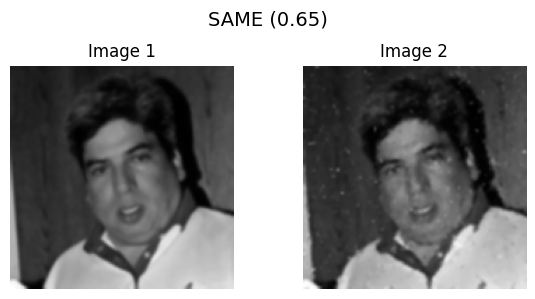

In [24]:
img1 = input("Enter Reference Image Path: ")
img2 = input("Enter Distorted Image Path: ")
verify_pair(img1, img2, model, threshold=optimal_threshold) #


Enter Reference Image Path: /content/drive/MyDrive/Large_task_B/train/Aishwarya_Rai/Aishwarya_Rai_0001.jpg
Enter Distorted Image Path: /content/drive/MyDrive/Large_task_B/train/Aishwarya_Rai/distortion/Aishwarya_Rai_0001_blurred.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

 Confidence Score: 0.8903
 SAME person


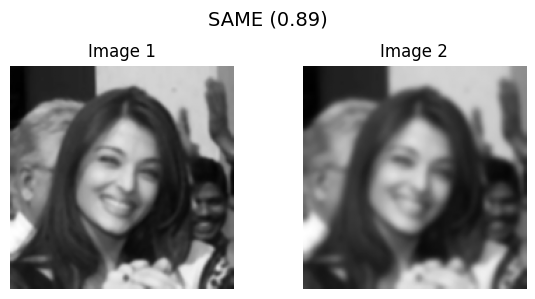

In [25]:
img1 = input("Enter Reference Image Path: ")
img2 = input("Enter Distorted Image Path: ")
verify_pair(img1, img2, model, threshold=optimal_threshold) #


Enter Reference Image Path: /content/drive/MyDrive/Large_task_B/train/Asif_Ali_Zardari/Asif_Ali_Zardari_0001.jpg
Enter Distorted Image Path: /content/drive/MyDrive/Large_task_B/train/Asif_Ali_Zardari/distortion/Asif_Ali_Zardari_0001_rainy.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

 Confidence Score: 0.9997
 SAME person


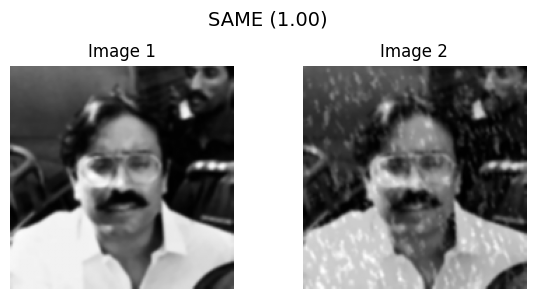

In [26]:
img1 = input("Enter Reference Image Path: ")
img2 = input("Enter Distorted Image Path: ")
verify_pair(img1, img2, model, threshold=optimal_threshold) #


Enter Reference Image Path: /content/drive/MyDrive/Large_task_B/train/Asif_Ali_Zardari/Asif_Ali_Zardari_0001.jpg
Enter Distorted Image Path: /content/drive/MyDrive/Large_task_B/train/Askar_Akayev/distortion/Askar_Akayev_0001_foggy.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

 Confidence Score: 0.0010
 DIFFERENT persons


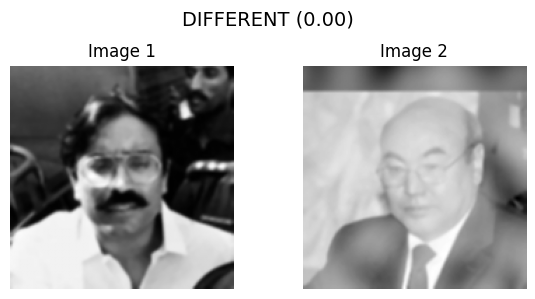

In [27]:
img1 = input("Enter Reference Image Path: ")
img2 = input("Enter Distorted Image Path: ")
verify_pair(img1, img2, model, threshold=optimal_threshold) #


Enter Reference Image Path: /content/drive/MyDrive/Large_task_B/train/Cesar_Maia/Cesar_Maia_0001.jpg
Enter Distorted Image Path: /content/drive/MyDrive/Large_task_B/train/Cesar_Maia/distortion/Cesar_Maia_0001_noisy.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

 Confidence Score: 0.6352
 SAME person


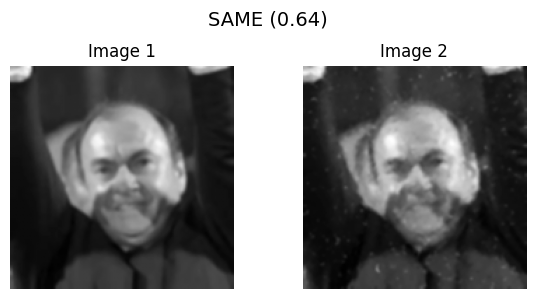

In [28]:
img1 = input("Enter Reference Image Path: ")
img2 = input("Enter Distorted Image Path: ")
verify_pair(img1, img2, model, threshold=optimal_threshold) #
